# Final Project - Criteo Labs Display Advertising Challenge
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019`__

__`Team: Chi Iong Ansjory, Catherine Cao, Scott Xu`__

Table of Content:
- [0. Background](#background)
- [1. Question Formulation](#question_formulation)
- [2. Algorithm Explanation](#algorithm_explanation)
- [3. EDA & Discussion of Challenges](#eda_challenges)
- [4. Algorithm Implementation](#algorithm_implementation)
- [5. Application of Course Concepts](#course_concepts_application)

<a id='background'></a>
# 0. Background

Criteo Labs is a leading global technology company that specializes in performance display advertising, working with over 4,000 e-commerce companies around the world. Their technology takes an algorithmic approach to determining what user they show an advertisement to, when, and for what products. For billions of unique advertisements that are created and displayed at lightning fast speeds every day.

Display advertising is a billion dollar effort and one of the central uses of Machine Learning on the Internet. However, its data and methods are usually kept confidential. Through the Kaggle research competition, Criteo Labs is sharing a week’s worth of data for participants to develop models predicting advertisement click-through rate (CTR). Given a user and the page being visited, what is the probability that the user will click on a given advertisement?

Source: https://www.kaggle.com/c/criteo-display-ad-challenge

For the dataset, the smaller version is no longer available from Kaggle. The full-size version needs to be used instead from Criteo Labs.

Source: https://www.kaggle.com/c/criteo-display-ad-challenge/data (smaller version - obsoleted); http://labs.criteo.com/2014/02/kaggle-display-advertising-challenge-dataset/ (full-size version)

### Notebook Set-Up

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import os

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
MAX_MEMORY = "64g"
app_name = "fpj_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .config("spark.executor.memory", MAX_MEMORY)\
        .config("spark.driver.memory", MAX_MEMORY) \
        .getOrCreate()
sc = spark.sparkContext

from pyspark.sql.types import *
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pyspark.sql.functions as f

<a id='question_formulation'></a>
# 1. Question Formulation

The goal of this analysis is to benchmark the most accurate ML algorithms for click through rates (CTR) estimation.

The dataset contexts were entirely abstracted due to the confidentiality reason making the contents less intuitive. The main challenge from the limitation of the dataset is the lack of representation of each feature. With such condition, the primary consideration of ML algorithms will solely be based on the volume and completeness (% missing value) of the dataset, the data type and number of features available. This becomes an exercise of finding a more accurate ML algorithm to predict the target variable, which is the CTR.

For more ideal situation with more customer relevant information, such as demography, consumer preference and behavior, the better we could fine tune the model to achieve higher CTR. According to WordStream, a CTR of over 2% for a search advertisement is extraordinary. For Display Advertisements, which is the business of Criteo, a CTR of above 0.4% considers very good.

Source: https://www.wordstream.com/average-ctr

The incentive of understanding drivers of an individual user to click on a link has significant monetary implications. If we develop a model that predicts CTR more accurately, digital advertising could be more efficient by avoiding billion dollars of waste annually on mistargeted users. By targeting customers of interest better, waste of advertisement spending will be reduced, and the profit margins will increase. Consequently, online retailers have higher interest in ensuring that ads are properly targeted to achieve high CTR.

<a id='algorithm_explanation'></a>
# 2. Algorithm Explanation

Based on the volume of the full-size dataset (11GB), we decided to leverage PySpark and Spark ML Library (MLLib) packages. In addressing our project question of correctly predicting CTR, we evaluated following 3 algorithms: Logistic Regression (LR), Gradient Boosted Tree (GBT), and Random Forest (RF).

Source: https://spark.apache.org/docs/2.3.0/ml-guide.html

__Logistic Regression__ is a popular method to predict a categorical response. It is a special case of Generalized Linear models that predicts the probability of the outcomes. If we model this sample data with a logistic regression, we assume that there are parameters $\beta_1$ to $\beta_{22}$ that:

$$ y = \frac{exp(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_{22} x_{22})}{1 + exp(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_{22} x_{22})} $$

This is in the matrix form of:

$$ \theta^T = \big[ \beta_0 \beta_1 ... \beta_{22} \big] $$

Let sigmoid function $G(z)$ be:

$$ G(z) = \frac{1}{1 + e^{-z}} $$

Each prediction will be:

$$ y_i = G(x_i \theta^T) $$

The log loss function for the logistic regression is defined as:

$$ J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} (y_i log(H(x_i)) - (1-y_i)log(1-H(x_i)))$$

We can think of the log loss function as the error of our predictions and the process of solving for $\beta$'s as to minimize the log loss function. In order to do that, we can use the method of gradient descent where we iteratively adjust the coefficients $\theta$ to the direction that decreases the log loss function. The direction is given to us by the derivative of the log loss function.

Taking a derivative of the log loss function with respect to $\theta$ to get the gradient:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (H(x_i)-y_i) * x_{ij}$$

With the gradient computed in every iteration with $\alpha$ as the learning rate, we get the next $\theta$ by:

$$ \theta' = \theta - \alpha * \frac{\partial J(\theta)}{\partial \theta_j} $$

To illustrate math calculations, randomly pick 5 samples from __train.txt__ as toy example with 2 numeric columns ($x_1, x_2$) and 1 one-hot encoded categorical column ($x_3$) 

| y | x1 | x2 | x3 |
|---|----|----|----|
| 0 | 1  | 2  | 1  | 
| 0 | 2  | 4  | 1  |
| 1 | 1  | 0  | 1  |
| 1 | 0  | 16 | 0  |
| 1 | 3  | 13 | 0  |

The logistic regression model takes real-valued inputs and makes a prediction as to the probability of input belonging to default class (class 0). If  probabilty is greater than 0.5, it classifies as default class 0; or else it is class 1.

For this toy sample, the logistic regression has 4 coefficients just like linear regression:

$$ output = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 $$

The job of the learning algorithm is to discover the best values for all coefficients based on training dataset. The output will then be transformed into a probability using logistic function:

$$ p(class) = \frac{1}{1 + e^{-output}} $$

We can estimate values of coefficients using Stochastic Gradient Descent. Given each training instance, calculate a prediction using current values of coefficients, and then calculate new coefficient values based on error in the prediction. The process is repeated until model is accurate enough.

To begin with the calculation: $$ \beta_0 = \beta_1 = \beta_2 = \beta_3 = 0 $$

Prediction for first training instance, and new coefficient: 

$$ y=0, x_1=1, x_2=2, x_3=1 $$
$$ prediction = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2)}} = 0.5$$

Then, new coefficients can be calculated based on the prediction with $\alpha = 0.3$:
$$ \beta = \beta + \alpha * (y - prediction) * prediction * (1 - prediction) * x $$
$$ \beta_0 = 0 + 0.3 * (0-0.5) * 0.5 * (1-0.5) * 1 = -0.0375 $$
$$ \beta_1 = 0 + 0.3 * (0-0.5) * 0.5 * (1-0.5) * 1 = -0.0375 $$
$$ \beta_2 = 0 + 0.3 * (0-0.5) * 0.5 * (1-0.5) * 2 = -0.075 $$
$$ \beta_3 = 0 + 0.3 * (0-0.5) * 0.5 * (1-0.5) * 1 = -0.0375 $$
 
| Epoch | Prediction | $\beta_0$ | $\beta_1$ | $\beta_2$ | $\beta_3$ |
|-------|------------|----|----|----|----|
| 1 | 0.5 | -0.0375 | -0.0375 | -0.075 | -0.0375 |
| 2 | 0.33 | -0.059 | -0.081 | -0.162 | -0.059 | 
| 3 | 0.48 | -0.02 | -0.042 | -0.162 | -0.02 |
| 4 | 0.07 | -0.0018 | -0.042 | 0.46 | -0.02 |
| 5 | 0.99 | -0.0018 | -0.042 | 0.46 | -0.02 |

By following the same prediction model with epoches covering all training dataset with all columns, we will end up with the coefficients to be used to predict the target variable with the test dataset.

__Gradient Boosted Tree__ is ensembles of decision trees. It iteratively trains decision trees in order to minimize a loss function. GBT handles continuous and categorical features and are able to capture non-linearities and feature interactions. 

For log loss function for GBT classification is defined as:

$$ J(\theta) = 2 \sum_{i=1}^{m} log(1 + exp(-2 y_i H(x_i))) $$

__Random Forest__ is an ensemble method for classification and regression. The algorithm creates multiple trees. Each tree will give a prediction on its own. And final prediction is the most common from all the trees (classification) or the average (regression). In order to remove the correlation between each tree, it uses bagging to sample the training data and the features. So, each tree will have slightly different input. Overall random forest helps improve the model performance and avoid the overfitting.

There are trade-offs between GBT and RF in the training processes. GBT trains one tree at a time and RF can train multiple trees in parallel. Also, RF can be less prone to overfitting. Training more trees in RF reduces likelihood of overfitting, but training more trees with GBT increases the likelihood of overfitting.

Generally, based on our discussion in class, in the order from good to bad, GBT is better than RF, then RF is better than LR. We will further verify by the algorithm implementations after the EDA.

<a id='eda_challenges'></a>
# 3. EDA & Discussion of Challenges

The main challenges are the dataset given for this analysis has no column labels. We can't leverage any of our pre-existing knowledge about how online ads are served and CTR is computed in understanding the data. This means we have to put in extra effort in analyzing the data so we can understand the relationships between different features in the dataset and process them appropriately.

Another challenge that we later found in EDA is the amount of missing data. Two variables in the dataset, I12 and C22, have 76% missing, while 6 other variables have around 50% of data missing. We could not simply omit the missing data, since we would be throwing away a large amount of data that way. Therefore, for the two variables with 76% missing, we decided to not include the variables in the model. For the rest of the missing data, we will impute with mean for the numeric features, and mode for the categorical features.

The last challenge we face is the large number of categories for some of the categorical variables. The EDA revealed that some categorical variables have hundreds of thousands levels. This poses a challenge to applying the algorithms to the data. Some algorithms, for example logistic regression, require transformation of categorical variables via one-hot encoding. With features of many levels, this produces a large amount of features, creating more challenges to the already enormous data size.

__train.txt__ is a dataset of 11GB and __test.txt__ is a dataset of 1.5GB. There is an additional column for label in __train.txt__ but not in __test.txt__. So, __train.txt__ will be splitted 70%/30% for training data and test data.

First of all, loading the __train.txt__ raw dataset into RDD, and look at the first 5 rows of data.

In [5]:
# load the raw data into an RDD
trainRDD = sc.textFile('data/train.txt')

In [6]:
# take a look at raw data
trainRDD.take(5)

['0\t1\t1\t5\t0\t1382\t4\t15\t2\t181\t1\t2\t\t2\t68fd1e64\t80e26c9b\tfb936136\t7b4723c4\t25c83c98\t7e0ccccf\tde7995b8\t1f89b562\ta73ee510\ta8cd5504\tb2cb9c98\t37c9c164\t2824a5f6\t1adce6ef\t8ba8b39a\t891b62e7\te5ba7672\tf54016b9\t21ddcdc9\tb1252a9d\t07b5194c\t\t3a171ecb\tc5c50484\te8b83407\t9727dd16',
 '0\t2\t0\t44\t1\t102\t8\t2\t2\t4\t1\t1\t\t4\t68fd1e64\tf0cf0024\t6f67f7e5\t41274cd7\t25c83c98\tfe6b92e5\t922afcc0\t0b153874\ta73ee510\t2b53e5fb\t4f1b46f3\t623049e6\td7020589\tb28479f6\te6c5b5cd\tc92f3b61\t07c540c4\tb04e4670\t21ddcdc9\t5840adea\t60f6221e\t\t3a171ecb\t43f13e8b\te8b83407\t731c3655',
 '0\t2\t0\t1\t14\t767\t89\t4\t2\t245\t1\t3\t3\t45\t287e684f\t0a519c5c\t02cf9876\tc18be181\t25c83c98\t7e0ccccf\tc78204a1\t0b153874\ta73ee510\t3b08e48b\t5f5e6091\t8fe001f4\taa655a2f\t07d13a8f\t6dc710ed\t36103458\t8efede7f\t3412118d\t\t\te587c466\tad3062eb\t3a171ecb\t3b183c5c\t\t',
 '0\t\t893\t\t\t4392\t\t0\t0\t0\t\t0\t\t\t68fd1e64\t2c16a946\ta9a87e68\t2e17d6f6\t25c83c98\tfe6b92e5\t2e8a689b\t0b15387

__train.txt__ is essentially a text file with tab-separated values, in which all tab-delimited dataset need to be splitted into variables. A header also needs to be added for the identified target numeric variable, 13 numeric features, and 26 categorical features. Then, create a train dataframe with the header, cast integer variables to its type, verify the schema, and the total count of data.

In [7]:
# split variables
temp_var = trainRDD.map(lambda x: x.split("\t"))

In [8]:
# create header for dataset with numeric and categorical features
numeric_features = ['I'+str(i) for i in range(1,14)]
categorical_features = ['C'+str(i) for i in range(1,27)]
header = ['target'] + numeric_features + categorical_features

In [9]:
# create and look at pyspark dataframe
train_df = temp_var.toDF(header)
train_df.show()

+------+---+---+---+---+-----+---+---+---+----+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|target| I1| I2| I3| I4|   I5| I6| I7| I8|  I9|I10|I11|I12|I13|      C1|      C2|      C3|      C4|      C5|      C6|      C7|      C8|      C9|     C10|     C11|     C12|     C13|     C14|     C15|     C16|     C17|     C18|     C19|     C20|     C21|     C22|     C23|     C24|     C25|     C26|
+------+---+---+---+---+-----+---+---+---+----+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|     0|  1|  1|  5|  0| 1382|  4| 15|  2| 181|  1|  2|   |  2|68fd1e64|80e26c9b|fb936136|7b4723c4|25c83c9

In [10]:
# cast integer variables to integer type
for var in ['target'] + numeric_features:
    train_df = train_df.withColumn(var, train_df[var].cast(IntegerType()))

In [11]:
# check schema
train_df.printSchema()

root
 |-- target: integer (nullable = true)
 |-- I1: integer (nullable = true)
 |-- I2: integer (nullable = true)
 |-- I3: integer (nullable = true)
 |-- I4: integer (nullable = true)
 |-- I5: integer (nullable = true)
 |-- I6: integer (nullable = true)
 |-- I7: integer (nullable = true)
 |-- I8: integer (nullable = true)
 |-- I9: integer (nullable = true)
 |-- I10: integer (nullable = true)
 |-- I11: integer (nullable = true)
 |-- I12: integer (nullable = true)
 |-- I13: integer (nullable = true)
 |-- C1: string (nullable = true)
 |-- C2: string (nullable = true)
 |-- C3: string (nullable = true)
 |-- C4: string (nullable = true)
 |-- C5: string (nullable = true)
 |-- C6: string (nullable = true)
 |-- C7: string (nullable = true)
 |-- C8: string (nullable = true)
 |-- C9: string (nullable = true)
 |-- C10: string (nullable = true)
 |-- C11: string (nullable = true)
 |-- C12: string (nullable = true)
 |-- C13: string (nullable = true)
 |-- C14: string (nullable = true)
 |-- C15: string

In [12]:
# how many records do we have
total_count = train_df.count()
total_count

45840617

Now, the next challenges are to decide how to handle missing values in the variables. There are missing values for both numeric and categorical features, but not the target variable. For missing numeric variables, they show up as __NaN__. For some reason, missing categorical variables are not recognized as __NaN__, replace them with __None__. The distribution of target variable is fairly balanced. 

In [22]:
# replace missing categorical variables not recognized as NA with the None
train_df = train_df.replace('', None, categorical_features)

In [19]:
# take a look at data
pd.DataFrame(train_df.take(5), columns=train_df.columns).transpose()

0         1         2         3         4
target         0         0         0         0         0
I1             1         2         2       NaN         3
I2             1         0         0       893        -1
I3             5        44         1       NaN       NaN
I4             0         1        14       NaN         0
I5          1382       102       767      4392         2
I6             4         8        89       NaN         0
I7            15         2         4         0         3
I8             2         2         2         0         0
I9           181         4       245         0         0
I10            1         1         1       NaN         1
I11            2         1         3         0         1
I12          NaN       NaN         3       NaN       NaN
I13            2         4        45       NaN         0
C1      68fd1e64  68fd1e64  287e684f  68fd1e64  8cf07265
C2      80e26c9b  f0cf0024  0a519c5c  2c16a946  ae46a29d
C3      fb936136  6f67f7e5  02cf9876  a9a87e68  c81688bb
C4      7b4723c4  41274cd7  c18be181  2e17d6f6  f922efad
C5      25c83c98  25c83c98  25c83c98  25c83c98  25c83c98
C6      7e0ccccf  fe6b92e5  7e0ccccf  fe6b92e5  13718bbd
C7      de7995b8  922afcc0  c78204a1  2e8a689b  ad9fa255
C8      1f89b562  0b153874  0b153874  0b153874  0b153874
C9      a73ee510  a73ee510  a73ee510  a73ee510  a73ee510
C10     a8cd5504  2b53e5fb  3b08e48b  efea433b  5282c137
C11     b2cb9c98  4f1b46f3  5f5e6091  e51ddf94  e5d8af57
C12     37c9c164  623049e6  8fe001f4  a30567ca  66a76a26
C13     2824a5f6  d7020589  aa655a2f  3516f6e6  f06c53ac
C14     1adce6ef  b28479f6  07d13a8f  07d13a8f  1adce6ef
C15     8ba8b39a  e6c5b5cd  6dc710ed  18231224  8ff4b403
C16     891b62e7  c92f3b61  36103458  52b8680f  01adbab4
C17     e5ba7672  07c540c4  8efede7f  1e88c74f  1e88c74f
C18     f54016b9  b04e4670  3412118d  74ef3502  26b3c7a7
C19     21ddcdc9  21ddcdc9      None      None      None
C20     b1252a9d  5840adea      None      None      None
C21     07b5194c  60f6221e  e587c466  6b3a5ca6  21c9516a
C22         None      None  ad3062eb      None      None
C23     3a171ecb  3a171ecb  3a171ecb  3a171ecb  32c7478e
C24     c5c50484  43f13e8b  3b183c5c  9117a34a  b34f3128
C25     e8b83407  e8b83407      None      None      None
C26     9727dd16  731c3655      None      None      None

In [20]:
# look at missing statistics
non_missing = train_df.summary("count")
missing_summary = non_missing.toPandas().drop(['summary'], axis=1).transpose()
missing_summary.columns = ['non-missing']
missing_summary['missing'] = total_count - missing_summary['non-missing'].astype('int64')
missing_summary['missing_pct'] = missing_summary['missing'] / total_count
missing_summary.sort_values(['missing_pct'], ascending=False)

non-missing   missing  missing_pct
I12       10768965  35071652     0.765078
C22       10885544  34955073     0.762535
I1        25047061  20793556     0.453606
I10       25047061  20793556     0.453606
C26       25667759  20172858     0.440065
C25       25667759  20172858     0.440065
C20       25667759  20172858     0.440065
C19       25667759  20172858     0.440065
I6        35588289  10252328     0.223652
I4        35903248   9937369     0.216781
I13       35903248   9937369     0.216781
I3        36001170   9839447     0.214645
C6        40299992   5540625     0.120867
I11       43857751   1982866     0.043256
I7        43857751   1982866     0.043256
I9        43857751   1982866     0.043256
C21       44281144   1559473     0.034019
C12       44281144   1559473     0.034019
C24       44281144   1559473     0.034019
C4        44281144   1559473     0.034019
C3        44281144   1559473     0.034019
C16       44281144   1559473     0.034019
I5        44657500   1183117     0.025809
I8        45817844     22773     0.000497
C23       45840617         0     0.000000
C15       45840617         0     0.000000
C18       45840617         0     0.000000
C17       45840617         0     0.000000
target    45840617         0     0.000000
C14       45840617         0     0.000000
C13       45840617         0     0.000000
C11       45840617         0     0.000000
C10       45840617         0     0.000000
C9        45840617         0     0.000000
C8        45840617         0     0.000000
C5        45840617         0     0.000000
C2        45840617         0     0.000000
C1        45840617         0     0.000000
I2        45840617         0     0.000000
C7        45840617         0     0.000000

We observe some high missing percentage for variables I12 and C22. We will omit these two variables as they don't carry enough information. For the rest of the missing variables, we will look at statistics of each feature to decide how to impute missing values.

In [14]:
# look at target variable distribution - fairly balanced
train_df.groupBy('target').count().toPandas()

target     count
0       1  11745438
1       0  34095179

Next, take 1% of dataset as the sample to perform more EDA with summary statistics, correlation matrix, and scatterplot for numeric features, and summary statistics for categorical features.

In [25]:
# take 1% of data as a sample for more EDA
sample = train_df.sample(0.01, 666)
sample.count()

459205

In [26]:
# look at summary statistics of numeric features
num_summary = sample.select(numeric_features).describe()
num_summary_pd = num_summary.toPandas().transpose()
num_summary_pd.columns = num_summary_pd.iloc[0]
num_summary_pd = num_summary_pd[1:]
num_summary_pd

summary   count                mean              stddev min      max
I1       251011  3.4760030436913123   9.136522184361425   0      640
I2       459205  106.28502302893044  390.40061338834283  -2    21478
I3       360136  26.599587378101607   379.5516093659997   0    65535
I4       359474   7.330168524010081   8.912915285544344   0      707
I5       447231  18447.941985238052   69124.21111814637   0  2311254
I6       356154  115.40899723153467   340.7259645665916   0    48611
I7       439178   16.43611018766878    67.9846460184096   0    10625
I8       459009   12.51132548599265  17.156700486415932   0     6047
I9       439178  106.33837077449235   224.7795762846696   0    25618
I10      251011  0.6165307496484218  0.6843948772337364   0        8
I11      439178   2.746424001202246   5.258414083196825   0      136
I12      108150  0.9782801664355062   5.061270086842182   0      329
I13      359474   8.215350762502991  19.408214166441805   0     6968

We have calculated the means of the numeric features. We will use this number to impute the missing values.

In [27]:
# correlation matrix of numeric features on sample data
numeric_data = sample.select(['target'] + numeric_features).toPandas()
corrmat = numeric_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

We noticed that a few variables are correlated. For example I7 and I11, I4 and I8, I1 and I7, etc. We will keep this in mind when we implement algorithms that maybe sensitive to collinearity, for example logistic regression.

In [28]:
# scatterplot of numeric features
sample_pd = sample.toPandas()
sample_nona = sample_pd.dropna()
sns.set()
cols = ['target'] + numeric_features
sns.pairplot(sample_nona[cols], height = 2.5)
plt.show()

This again shows the correlation between I7 and I11. We have also observed that a lot of numeric features have a very skewed distribution. This may pose a challenge when we later implement algorithms, especially for logistic regression where we assume variables are relatively normally distributed.

In [172]:
# look at summary statistics of categorical features in sample (mode, counts for mode, number of levels)
cat_summary = pd.DataFrame()
for i in categorical_features:
    cached = sample.groupBy(i).count().cache()
    mode = cached.orderBy('count', ascending=0).filter(i + "!=''").limit(1).toPandas()
    level = cached.count()
    mode['level'] = level
    mode['var'] = i
    mode.rename(columns={i:'mode'}, inplace=True)
    cat_summary = cat_summary.append(mode, ignore_index = True)
cat_summary

mode   count   level  var
0   05db9164  229880     993   C1
1   38a947a1   52183     542   C2
2   d032c263   11414  181656   C3
3   c18be181   16378   79764   C4
4   25c83c98  309003     220   C5
5   7e0ccccf  182511      15   C6
6   1c86e0eb    9465   10479   C7
7   0b153874  272482     456   C8
8   a73ee510  412667       3   C9
9   3b08e48b  101627   23613  C10
10  755e4a50   14560    4648  C11
11  dfbb09fb   11414  163537  C12
12  5978055e   14560    3117  C13
13  b28479f6  161367      26  C14
14  2d0bb053    6844    8017  C15
15  84898b2a   11415  128705  C16
16  e5ba7672  211572      10  C17
17  e88ffc9d   14695    3616  C18
18  21ddcdc9  158333    1702  C19
19  b1252a9d   87704       4  C20
20  0014c32a   11414  148998  C21
21  ad3062eb   62705      15  C22
22  32c7478e  202271      15  C23
23  3fdb382b   23925   29530  C24
24  001f3601   65625      62  C25
25  49d68486   18935   22024  C26

Here we observe that a lot of categorical variables have a large number of levels. This will increase our data size significantly after doing a one-hot encoding.

Finally, we decide to do imputation on the missing values. For numeric features, we impute with mean values of non-missing values; for categorical features, we impute with mode of non-missing values.

In [214]:
# impute missing values - numeric features impute with mean, categorical features impute with mode
num_means = list(num_summary_pd['mean'].astype('float64').round().astype('int64'))
cat_modes = list(cat_summary['mode'])
impute = dict(zip(numeric_features+categorical_features, num_means+cat_modes))
impute

{'I1': 4,
 'I2': 106,
 'I3': 27,
 'I4': 7,
 'I5': 18539,
 'I6': 116,
 'I7': 16,
 'I8': 13,
 'I9': 106,
 'I10': 1,
 'I11': 3,
 'I12': 1,
 'I13': 8,
 'C1': '05db9164',
 'C2': '38a947a1',
 'C3': 'd032c263',
 'C4': 'c18be181',
 'C5': '25c83c98',
 'C6': '7e0ccccf',
 'C7': '1c86e0eb',
 'C8': '0b153874',
 'C9': 'a73ee510',
 'C10': '3b08e48b',
 'C11': '755e4a50',
 'C12': 'dfbb09fb',
 'C13': '5978055e',
 'C14': 'b28479f6',
 'C15': '2d0bb053',
 'C16': '84898b2a',
 'C17': 'e5ba7672',
 'C18': 'e88ffc9d',
 'C19': '21ddcdc9',
 'C20': 'b1252a9d',
 'C21': '0014c32a',
 'C22': 'ad3062eb',
 'C23': '32c7478e',
 'C24': '3fdb382b',
 'C25': '001f3601',
 'C26': '49d68486'}

In [15]:
# save imputation to file
# import json 
# json = json.dumps(impute)
# f = open("imputation_int.json","w")
# f.write(json)
# f.close()

# load json file
f = open("imputation_int.json")
impute = json.load(f)
f.close()

In [16]:
# impute missing and take a look at imputed data
train_df_impute = train_df.fillna(impute)
train_df_impute.cache()
pd.DataFrame(train_df_impute.take(10), columns=train_df_impute.columns).transpose()

0         1         2         3         4         5         6  \
target         0         0         0         0         0         0         0   
I1             1         2         2         4         3         4         4   
I2             1         0         0       893        -1        -1         1   
I3             5        44         1        27        27        27         2   
I4             0         1        14         7         0         7         7   
I5          1382       102       767      4392         2     12824      3168   
I6             4         8        89       116         0       116       116   
I7            15         2         4         0         3         0         0   
I8             2         2         2         0         0         0         1   
I9           181         4       245         0         0         6         2   
I10            1         1         1         1         1         1         1   
I11            2         1         3         0         1         0         0   
I12            1         1         3         1         1         1         1   
I13            2         4        45         8         0         8         8   
C1      68fd1e64  68fd1e64  287e684f  68fd1e64  8cf07265  05db9164  439a44a4   
C2      80e26c9b  f0cf0024  0a519c5c  2c16a946  ae46a29d  6c9c9cf3  ad4527a2   
C3      fb936136  6f67f7e5  02cf9876  a9a87e68  c81688bb  2730ec9c  c02372d0   
C4      7b4723c4  41274cd7  c18be181  2e17d6f6  f922efad  5400db8b  d34ebbaa   
C5      25c83c98  25c83c98  25c83c98  25c83c98  25c83c98  43b19349  43b19349   
C6      7e0ccccf  fe6b92e5  7e0ccccf  fe6b92e5  13718bbd  6f6d9be8  fe6b92e5   
C7      de7995b8  922afcc0  c78204a1  2e8a689b  ad9fa255  53b5f978  4bc6ffea   
C8      1f89b562  0b153874  0b153874  0b153874  0b153874  0b153874  0b153874   
C9      a73ee510  a73ee510  a73ee510  a73ee510  a73ee510  a73ee510  a73ee510   
C10     a8cd5504  2b53e5fb  3b08e48b  efea433b  5282c137  3b08e48b  3b08e48b   
C11     b2cb9c98  4f1b46f3  5f5e6091  e51ddf94  e5d8af57  91e8fc27  a4609aab   
C12     37c9c164  623049e6  8fe001f4  a30567ca  66a76a26  be45b877  14d63538   
C13     2824a5f6  d7020589  aa655a2f  3516f6e6  f06c53ac  9ff13f22  772a00d7   
C14     1adce6ef  b28479f6  07d13a8f  07d13a8f  1adce6ef  07d13a8f  07d13a8f   
C15     8ba8b39a  e6c5b5cd  6dc710ed  18231224  8ff4b403  06969a20  f9d1382e   
C16     891b62e7  c92f3b61  36103458  52b8680f  01adbab4  9bc7fff5  b00d3dc9   
C17     e5ba7672  07c540c4  8efede7f  1e88c74f  1e88c74f  776ce399  776ce399   
C18     f54016b9  b04e4670  3412118d  74ef3502  26b3c7a7  92555263  cdfa8259   
C19     21ddcdc9  21ddcdc9  21ddcdc9  21ddcdc9  21ddcdc9  21ddcdc9  21ddcdc9   
C20     b1252a9d  5840adea  b1252a9d  b1252a9d  b1252a9d  b1252a9d  b1252a9d   
C21     07b5194c  60f6221e  e587c466  6b3a5ca6  21c9516a  242bb710  20062612   
C22     ad3062eb  ad3062eb  ad3062eb  ad3062eb  ad3062eb  8ec974f4  ad3062eb   
C23     3a171ecb  3a171ecb  3a171ecb  3a171ecb  32c7478e  be7c41b4  93bad2c0   
C24     c5c50484  43f13e8b  3b183c5c  9117a34a  b34f3128  72c78f11  1b256e61   
C25     e8b83407  e8b83407  001f3601  001f3601  001f3601  001f3601  001f3601   
C26     9727dd16  731c3655  49d68486  49d68486  49d68486  49d68486  49d68486   

               7         8         9  
target         1         0         0  
I1             1         4         4  
I2             4        44        35  
I3             2         4        27  
I4             0         8         1  
I5             0     19010     33737  
I6             0       249        21  
I7             1        28         1  
I8             0        31         2  
I9             0       141         3  
I10            1         1         1  
I11            1         1         1  
I12            1         1         1  
I13            0         8         1  
C1      68fd1e64  05db9164  05db9164  
C2      2c16a946  d833535f  510b40a5  
C3      503b9dbc  d032c263  d03e7c24  
C4      e4dbea90  c18be181  eb1f

In [17]:
train_df_impute.printSchema()

root
 |-- target: integer (nullable = true)
 |-- I1: integer (nullable = false)
 |-- I2: integer (nullable = false)
 |-- I3: integer (nullable = false)
 |-- I4: integer (nullable = false)
 |-- I5: integer (nullable = false)
 |-- I6: integer (nullable = false)
 |-- I7: integer (nullable = false)
 |-- I8: integer (nullable = false)
 |-- I9: integer (nullable = false)
 |-- I10: integer (nullable = false)
 |-- I11: integer (nullable = false)
 |-- I12: integer (nullable = false)
 |-- I13: integer (nullable = false)
 |-- C1: string (nullable = false)
 |-- C2: string (nullable = false)
 |-- C3: string (nullable = false)
 |-- C4: string (nullable = false)
 |-- C5: string (nullable = false)
 |-- C6: string (nullable = false)
 |-- C7: string (nullable = false)
 |-- C8: string (nullable = false)
 |-- C9: string (nullable = false)
 |-- C10: string (nullable = false)
 |-- C11: string (nullable = false)
 |-- C12: string (nullable = false)
 |-- C13: string (nullable = false)
 |-- C14: string (nullabl

<a id='algorithm_implementation'></a>
# 4. Algorithm Implementation

## Logistic Regression

In [62]:
numeric_features = ['I'+str(i) for i in [x for x in range(1, 14) if x != 12]] # drop I12 with 76% missing
#categorical_features = ['C'+str(i) for i in [x for x in range(1, 27) if x != 22]] # drop C22 with 76% missing
categorical_features = ['C6','C9','C14','C17','C20','C23','C25']

stages = []

for i in categorical_features:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol = i, outputCol = i + 'Index', handleInvalid="skip")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[i + "classVec"])
    # Add stages
    stages += [stringIndexer, encoder]
    
# Transform all features into a vector using VectorAssembler
assemblerInputs = [c + "classVec" for c in categorical_features] + numeric_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Normalize
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
stages += [scaler]

In [ ]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train_df_impute)
df = pipelineModel.transform(train_df_impute)
df.printSchema()

In [17]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

0  \
target                                                          0   
I1                                                              1   
I2                                                              1   
I3                                                              5   
I4                                                              0   
I5                                                           1382   
I6                                                              4   
I7                                                             15   
I8                                                              2   
I9                                                            181   
I10                                                             1   
I11                                                             2   
I12                                                             1   
I13                                                             2   
C1                                                       68fd1e64   
C2                                                       80e26c9b   
C3                                                       fb936136   
C4                                                       7b4723c4   
C5                                                       25c83c98   
C6                                                       7e0ccccf   
C7                                                       de7995b8   
C8                                                       1f89b562   
C9                                                       a73ee510   
C10                                                      a8cd5504   
C11                                                      b2cb9c98   
C12                                                      37c9c164   
C13                                                      2824a5f6   
C14                                                      1adce6ef   
C15                                                      8ba8b39a   
C16                                                      891b62e7   
C17                                                      e5ba7672   
C18                                                      f54016b9   
C19                                                      21ddcdc9   
C20                                                      b1252a9d   
C21                                                      07b5194c   
C22                                                      ad3062eb   
C23                                                      3a171ecb   
C24                                                      c5c50484   
C25                                                      e8b83407   
C26                                                      9727dd16   
C6Index                                                         0   
C6classVec      (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
C9Index                                                         0   
C9classVec                                             (1.0, 0.0)   
C14Index                                                        2   
C14classVec     (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
C17Index                                                        0   
C17classVec         (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
C20Index                                                        0   
C20classVec                                            (1.0, 0.0)   
C23Index                                                        1   
C23classVec     (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
C25Index                                                        1   
C25classVec     (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
features        (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
scaledFeatures  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                1  \
target                                                       

In [18]:
df.persist()
train_df_impute.unpersist()

DataFrame[target: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string]

In [19]:
# split data into train and test sets
train, test = df.randomSplit([0.7, 0.3], seed = 666)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32089680
Test Dataset Count: 13750937


In [20]:
df.unpersist()
train.persist()
test.persist()

DataFrame[target: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, C6Index: double, C6classVec: vector, C9Index: double, C9classVec: vector, C14Index: double, C14classVec: vector, C17Index: double, C17classVec: vector, C20Index: double, C20classVec: vector, C23Index: double, C23classVec: vector, C25Index: double, C25classVec: vector, features: vector, scaledFeatures: vector]

In [21]:
# fit logistic regression model
lr = LogisticRegression(featuresCol = 'scaledFeatures', labelCol = 'target', maxIter=10)
lrModel = lr.fit(train)

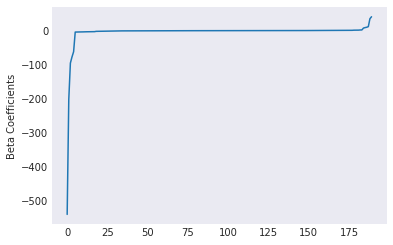

In [23]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [ ]:
trainingSummary = lrModel.summary

In [24]:
# prediction on hold out data
predictions = lrModel.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol = "target")

In [25]:
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.710480013975711


In [26]:
pd.DataFrame(predictions.take(5), columns=predictions.columns).transpose()

0  \
target                                                          0   
I1                                                              0   
I2                                                             -2   
I3                                                              9   
I4                                                              1   
I5                                                           7176   
I6                                                            171   
I7                                                              1   
I8                                                             35   
I9                                                             93   
I10                                                             0   
I11                                                             1   
I12                                                             1   
I13                                                             1   
C1                                                       05db9164   
C2                                                       80e26c9b   
C3                                                       ff030570   
C4                                                       85dd697c   
C5                                                       f3474129   
C6                                                       7e0ccccf   
C7                                                       e168afff   
C8                                                       5b392875   
C9                                                       a73ee510   
C10                                                      de6200f0   
C11                                                      208d9dd6   
C12                                                      8229bc5b   
C13                                                      59dd51b4   
C14                                                      8ceecbc8   
C15                                                      8d015bd8   
C16                                                      da441c7e   
C17                                                      d4bb7bd8   
C18                                                      005c6740   
C19                                                      21ddcdc9   
C20                                                      5840adea   
C21                                                      5a9032d6   
C22                                                      ad3062eb   
C23                                                      55dd3565   
C24                                                      1793a828   
C25                                                      e8b83407   
C26                                                      9904c656   
C6Index                                                         0   
C6classVec      (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
C9Index                                                         0   
C9classVec                                             (1.0, 0.0)   
C14Index                                                        6   
C14classVec     (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
C17Index                                                        2   
C17classVec         (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
C20Index                                                        1   
C20classVec                                            (0.0, 1.0)   
C23Index                                                        6   
C23classVec     (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
C25Index                                                        1   
C25classVec     (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
features        (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
scaledFeatures  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
rawPrediction             [3.544521628196761, -3.544521628196761]   
probability            [0.9719283421070816, 0.0280716578929184

In [1]:
# calculate log loss on hold out set
secondelement=f.udf(lambda v:float(v[1]),FloatType())

log_loss = (predictions.select(secondelement('probability').alias('probability'), 'target')\
    .withColumn('logloss', -f.col('target')*f.log(f.col('probability')) - (1.-f.col('target'))*f.log(1.-f.col('probability'))))

logloss = log_loss.agg(f.mean('logloss').alias('ll')).collect()[0]['ll']
logloss

Log loss was around 0.51

Now generate final prediction on true test set.

In [30]:
# process test data

# split variables
temp_var = testRDD.map(lambda x: x.split("\t"))

# creating header for data
numeric_features = ['I'+str(i) for i in range(1, 14)]
categorical_features = ['C'+str(i) for i in range(1, 27)]
header = numeric_features + categorical_features

# create pyspark dataframe
test_df = temp_var.toDF(header)

# cast integer variables to integer type
for var in numeric_features:
    test_df =test_df.withColumn(var, test_df[var].cast(IntegerType()))

# for some reason missing categorical variables are not recognized as NA, replacing with the None here
test_df = test_df.replace('', None, categorical_features)

# load json file
f = open("imputation_int.json")
impute = json.load(f)
f.close()

# impute missing and take a look at imputed data
test_df_impute = test_df.fillna(impute)
test_df_impute.cache()

In [34]:
# transform test data
test_df_tr = pipelineModel.transform(test_df_impute)

# prediction on test data
test_predictions = lrModel.transform(test_df_tr)

In [41]:
# generate submission file for kaggle
pred = test_predictions.select(firstelement('probability').alias('probability')).toPandas()
submission = pd.read_csv('random_submission.csv')
submission2 = pd.concat([submission['Id'], pred['probability']], axis=1)
submission2.rename(columns={'probability':'Predicted'}, inplace=True)
submission2.to_csv('predictions_lr.csv', index=False)

In [59]:
submission2.head()

Id  Predicted
0  60000000   0.790273
1  60000001   0.869363
2  60000002   0.811100
3  60000003   0.779192
4  60000004   0.793049

#### Discussion

There were some special challenges in implementing logistic regression on the CTR dataset as discussed in EDA. The first challenge was the large number of levels for categorical variables. We were not able to include all categorical variables with one-hot encoded values. After our cluster died a few time attempting to run the model on full data, we decided to scale down the number of categorical features to include in the model. We ended up including only features that had less than 100 levels. 

Another challenged we mentioned before was the skewness in numeric variables. Ideally we would have done a log transformation on the highly skewed numeric variables. However, this was not implemented here. We did however normalize the dataset, since the regularization term would be affected by different scales of the data.

Althought L2 regularization is used by default in the spark implementation of logistic regression, we have not done any parameter tuning in our simple model. I would expect the result to improve with parameter tuning.

As a result of these challenges, our naively implemented logistic regression model, without any tuning of parameters, received a log loss score of 0.52. It did not beat the logistic regression benchmark of 0.48. With modifications mentioned above, I would expect the results to improve further.

## Gradient Boosted Tree

In [18]:
numeric_features = ['I'+str(i) for i in [x for x in range(1, 14) if x != 12]] # drop I12 with 76% missing
categorical_features = ['C'+str(i) for i in [x for x in range(1, 27) if x!=22]] # drop C22 with 76% missing

# hasing categorical variables
hex_string=f.udf(lambda x:int(x,16),IntegerType())
for col in categorical_features:
    train_df_impute = train_df_impute.withColumn(col, hex_string(col))
    
stages = []

# Transform all features into a vector using VectorAssembler
assembler = VectorAssembler(inputCols=numeric_features+categorical_features, outputCol="features")
stages += [assembler]

# Index categorical features in feature vectors
indexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=50)
stages += [indexer]

In [ ]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train_df_impute)
df = pipelineModel.transform(train_df_impute)
df.printSchema()

In [18]:
train_df_impute.unpersist()
df.cache()

DataFrame[target: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, C1Index: double, C2Index: double, C4Index: double, C5Index: double, C6Index: double, C7Index: double, C8Index: double, C9Index: double, C10Index: double, C11Index: double, C13Index: double, C14Index: double, C15Index: double, C17Index: double, C18Index: double, C19Index: double, C20Index: double, C23Index: double, C24Index: double, C25Index: double, C26Index: double, features: vector, scaledFeatures: vector, indexedFeatures: vector]

In [19]:
# split data into train and test sets
train, test = df.randomSplit([0.7, 0.3], seed = 666)
# print("Training Dataset Count: " + str(train.count()))
# print("Test Dataset Count: " + str(test.count()))

In [20]:
train.persist()
test.persist()
df.unpersist()

DataFrame[target: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, C1Index: double, C2Index: double, C4Index: double, C5Index: double, C6Index: double, C7Index: double, C8Index: double, C9Index: double, C10Index: double, C11Index: double, C13Index: double, C14Index: double, C15Index: double, C17Index: double, C18Index: double, C19Index: double, C20Index: double, C23Index: double, C24Index: double, C25Index: double, C26Index: double, features: vector, scaledFeatures: vector, indexedFeatures: vector]

In [21]:
# fit GBM
gbt = GBTClassifier(featuresCol = 'indexedFeatures', labelCol = 'target', maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)

DataFrame[target: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, C1Index: double, C2Index: double, C4Index: double, C5Index: double, C6Index: double, C7Index: double, C8Index: double, C9Index: double, C10Index: double, C11Index: double, C13Index: double, C14Index: double, C15Index: double, C17Index: double, C18Index: double, C19Index: double, C20Index: double, C23Index: double, C24Index: double, C25Index: double, C26Index: double, features: vector, scaledFeatures: vector, indexedFeatures: vector, rawPrediction: vector, probability: vector, prediction: double]

In [22]:
predictions.select('target', 'rawPrediction', 'prediction', 'probability').show(10)

+------+--------------------+----------+--------------------+
|target|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     0|[0.87662401617579...|       0.0|[0.85236200562961...|
|     0|[0.77584110687556...|       0.0|[0.82515656298019...|
|     0|[0.52571574947574...|       0.0|[0.74104969151318...|
|     0|[0.42545522189775...|       0.0|[0.70075809395574...|
|     0|[0.78902948361532...|       0.0|[0.82892944472018...|
|     0|[1.01223448096350...|       0.0|[0.88334231921258...|
|     0|[0.51428527745944...|       0.0|[0.73663867425247...|
|     0|[0.50302081729404...|       0.0|[0.73224477657962...|
|     0|[0.53453169664196...|       0.0|[0.74441875832713...|
|     0|[0.83581827657656...|       0.0|[0.84179389421962...|
+------+--------------------+----------+--------------------+
only showing top 10 rows



In [24]:
secondelement=f.udf(lambda v:float(v[1]),FloatType())

log_loss = (predictions.select(secondelement('probability').alias('probability'), 'target')\
    .withColumn('logloss', -f.col('target')*f.log(f.col('probability')) - (1.-f.col('target'))*f.log(1.-f.col('probability'))))

logloss = log_loss.agg(f.mean('logloss').alias('ll')).collect()[0]['ll']
logloss

0.5100726544935856

#### Discussion
Gradient-boosted trees are ensembles of decision trees that sequentially uses the result of previous trees to train future trees. We tested gradient boosting model because it has been one of the most powerful classification models and has been used in many kaggle competitions and practical applications.

Our GBT model is again a naive and simplified model. We used the hashing trick to turn categorical variables into integers instead of the one-hot encoding to decrease running speed. We also used the VectorIndexer to index which variables should be treated as categorical variables.

Ideally we would do parameter training on the following parameters:
* depth - the maximum depth of a tree
* leaf size - the minimum number of observations allowed in a leaf
* max feature - the number of features to consider while searching for the split
* sample rate - the number of observations to sample for reach tree
* etc.

However due to the size of the data and limited time and computing power, we simply took the default setting and did not do any parameter tuning. The log loss result of the naively implemented GBT model is 0.51, slightly better than logistic regression. With parameter tunning we would expect the result to improve further.

## Random Forest

In [17]:
df.replace('', None, categorical_features)
with open("imputation_int.json") as json_file:  
    impute = json.load(json_file)
    del impute['C22']
    del impute['I12']
df_impute = df.replace('', None, categorical_features)
df_impute = df_impute.fillna(impute)

hex_string=f.udf(lambda x:int(x,16),IntegerType())

for col in categorical_features:
    df_impute = df_impute.withColumn(col,hex_string(col))

In [18]:
def preprocess(df):
    stages = []
#     categorical_features_index=[]
#    ['C1','C2','C5','C6','C8','C9','C11','C13','C14','C15','C17','C18','C19','C20','C22','C23','C25']
#     for categoricalCol in categorical_features:
#         stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
#         encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
#         #encoder = VectorIndexer(inputCol=[stringIndexer.getOutputCol()], outputCol=[categoricalCol + "classVec"])
#         categorical_features_index += [categoricalCol + 'Index']
#         stages += [stringIndexer,encoder]
    #print(categorical_features_index)

    vector_assembler = VectorAssembler( \
        inputCols= numeric_features+ categorical_features, \
        outputCol="features")

    stages += [vector_assembler] 
    pipeline = Pipeline(stages = stages)

    pipelineModel = pipeline.fit(df)
    df_temp = pipelineModel.transform(df)
    
    return df_temp, pipelineModel

In [19]:
start = time.time()
df_temp, pipelineModel = preprocess(df_impute)
print("Wall time: {} seconds".format(time.time() - start))
df_temp.printSchema()

Wall time: 0.02083730697631836 seconds
root
 |-- target: integer (nullable = true)
 |-- I1: integer (nullable = false)
 |-- I2: integer (nullable = false)
 |-- I3: integer (nullable = false)
 |-- I4: integer (nullable = false)
 |-- I5: integer (nullable = false)
 |-- I6: integer (nullable = false)
 |-- I7: integer (nullable = false)
 |-- I8: integer (nullable = false)
 |-- I9: integer (nullable = false)
 |-- I10: integer (nullable = false)
 |-- I11: integer (nullable = false)
 |-- I13: integer (nullable = false)
 |-- C1: integer (nullable = true)
 |-- C2: integer (nullable = true)
 |-- C3: integer (nullable = true)
 |-- C4: integer (nullable = true)
 |-- C5: integer (nullable = true)
 |-- C6: integer (nullable = true)
 |-- C7: integer (nullable = true)
 |-- C8: integer (nullable = true)
 |-- C9: integer (nullable = true)
 |-- C10: integer (nullable = true)
 |-- C11: integer (nullable = true)
 |-- C12: integer (nullable = true)
 |-- C13: integer (nullable = true)
 |-- C14: integer (null

In [10]:
(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
start = time.time()
rf = RandomForestClassifier(labelCol="target",\
featuresCol="features", numTrees=100)
model = rf.fit(trainingData)

predictions = model.transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol = "target")

print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
print("Wall time: {} seconds".format(time.time() - start))

Test Area Under ROC: 0.7083715760474067
Wall time: 3488.9581015110016 seconds


In [38]:
predictions

DataFrame[target: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, C6Index: double, C6classVec: vector, C9Index: double, C9classVec: vector, C14Index: double, C14classVec: vector, C17Index: double, C17classVec: vector, C20Index: double, C20classVec: vector, C23Index: double, C23classVec: vector, C25Index: double, C25classVec: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [27]:
predictions.select('target', 'rawPrediction', 'prediction', 'probability').show(10)

+------+--------------------+----------+--------------------+
|target|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     0|[85.9569560005486...|       0.0|[0.85956956000548...|
|     0|[81.0723273102391...|       0.0|[0.81072327310239...|
|     0|[76.8602831987373...|       0.0|[0.76860283198737...|
|     0|[84.1087912534379...|       0.0|[0.84108791253437...|
|     0|[79.3108344510999...|       0.0|[0.79310834451099...|
|     0|[75.0067298049367...|       0.0|[0.75006729804936...|
|     0|[81.5320252434899...|       0.0|[0.81532025243489...|
|     0|[81.3178605316716...|       0.0|[0.81317860531671...|
|     0|[78.7006942259489...|       0.0|[0.78700694225948...|
|     0|[84.2800906835654...|       0.0|[0.84280090683565...|
+------+--------------------+----------+--------------------+
only showing top 10 rows



In [11]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *
import math

def logloss(prob, actual):
    if actual == 1:
        return -math.log(prob)
    else:
        return -math.log(1-prob)

udf_logloss = udf(logloss, FloatType())

firstelement=udf(lambda v:float(v[1]),FloatType())
logloss = predictions.select(firstelement('probability').alias('probability'), 'target').withColumn("logloss", udf_logloss("probability","target"))\
       .groupby().avg('logloss').collect()
print (logloss)

[Row(avg(logloss)=0.5186227341338779)]


In [20]:
rdd_test = sc.textFile("./data/test.txt")
numeric_features = ['I'+str(i) for i in range(1, 14)]
categorical_features = ['C'+str(i) for i in range(1, 27)]
header_test = numeric_features + categorical_features
df_test = rdd_test.map(lambda x: x.split("\t")).toDF(header_test).cache()

for var in numeric_features:
    df_test =df_test.withColumn(var, df_test[var].cast(IntegerType()))
    
df_test.replace('', None, categorical_features)
with open("imputation_int.json") as json_file:  
    impute = json.load(json_file)
df_impute_test=df_test.replace('', None, categorical_features)
df_impute_test = df_impute_test.fillna(impute)

hex_string=udf(lambda x:int(x,16),IntegerType())

for col in categorical_features:
    df_impute_test = df_impute_test.withColumn(col,hex_string(col))

df_temp_test = pipelineModel.transform(df_impute_test)

predictions_test = model.transform(df_temp_test)

In [25]:
pred = predictions_test.select(firstelement('probability').alias('Predicted')).toPandas()
submission = pd.read_csv('random_submission.csv')
submission2 = pd.concat([submission['Id'], pred['Predicted']], axis=1)
#submission2.rename(columns={'probability':'Predicted'}, inplace=True)
submission2.to_csv('predictions_rf3.csv', index=False)

In [26]:
submission2.head()

Id  Predicted
0  60000000   0.179017
1  60000001   0.272029
2  60000002   0.355309
3  60000003   0.183668
4  60000004   0.333123

#### Discussion
Random forest is another ensembles of decision trees. Instead of building trees sequentially, it builds many shallow decision trees and summarizes the result from all of them.

Our approach to random forest is similar to gradient boosting, where we built a simple model with default parameters. Our result for random forest is comparable to gradient boosting. Parameter tuning would include tunning parameters like number of trees, feature sampling percentage, observation sampling percentage, etc.

The kaggle score of the simple random forest model is 0.52, slightly better than logistic regression, and slightly worse than gradient boosting.

We want to note that all of our models, despite using very different algorithms, had fairly similar scores. None of them were significantly better than another, and needless to say none of them ranked high on the leaderboard. In hindsight, there was a lot that could have been done to create a better model. We could have spent more time on missing data. For variables with many levels, we could have grouped the levels with very few observations into the same group, since they don't provide much information. We could have transformed our data so that they are more normally distributed for logistic regression. And for all three algorithms, we could have spent more time fine tuning the model parameters. 

We set out to find the best algorithm in predicting the click-through rate, and from this exercise we learned that there is no one magic algorithm that will produce a better prediction. Data pre-processing, feature engineering, algorithm selection, and parameter tuning must all come together in order to create a predictive model.

<a id='course_concepts_application'></a>
# 5. Application of Course Concepts

## Lazy Evaluation

Lazy evaluation is an evaluation strategy in programming to delay the evaluation of an expression until needed. It prevents repeated computation of the same expression for resource constraint. Spark utilizes lazy evaluation on data stored in the form of DataFrame and does not initiate the execution of transformations until an action is triggered. When multiple cells in Jupyter Notebook are executed, it is possible that data may remain intact if the cells being executed have not reached any action. For example, notebook cells without a "collect" statement (like count) would run instantly, but it will run a long time if there is a "collect" type of function. It is apparent that Spark is doing lazy evaluation, because it is not actually create the new data until a "collect" type of statement is executed.

Since we primarily use Spark MLLib from EDA, feature engineering of various transformations to the dataset to prepare it for subsequent ML algorithm implementation, performance and scalability are the keys for the volume of the dataset. As the dataset is relatively large, each transformation takes a long time and we would often try out the transformation on a smaller sample to see how well our machines can handle the workload. For practicality concern, understanding the lazy evaluating nature of Spark can help us better assess the time and computational resources required.


## One-Hot Encoding

One-hot encoding is a method of transforming categorical variables to binary vectors. Most ML algorithms are not capable of working with non-numerical values as-is, and they need to be converted in order to fit into ML algorithms as data input. Essentially, one-hot encoding is to map categorical values to integer values, and then convert each integer value to a binary vector which consists of zero values except the index of the integer marked with a 1.

For the given dataset, we identified the first 13 columns to be numerical and the remaining 26 to be categorical. For the featuring engineering, we used MLlib’s StringIndexer and OneHotEncoder functions respectively for each step in one-hot encoding the categorical. Scalability and performance concerns are from the number of levels generated based on the hash string. Those levels will in turn be translated into additional columns. We striked a balance of practicality and scalability/performance by excluding categorical variables that will yield excessive number of additional columns that will severely impact the performance.


## Gradient Descent

Gradient Descent is an optimization algorithm used to minimize a function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient. So, theoretically in gradient descent the parameters are updated after a whole pass through of the entire dataset. 

For Spark MLLib implementation, Gradient Descent uses mini batch instead for Logistic Regression. It can be parallelized by having each mapper calculating gradients on a subset of the data, then reducer combining all the gradients. The tradeoff will be the performance and scalability.

More practically, Stochastic Gradient Descent (SGD) computes the gradient for each update using a single training data point at random. The gradient calculated this way is a stochastic approximation to the gradient calculated using the entire training data. Each update is much faster to calculate than in batch gradient descent. Over many updates, we will head in the same direction. However, parallelization is a lot more challenging than Gradient Descent.